<a href="https://colab.research.google.com/github/haokeliu/colaboratory/blob/master/DeepLearn_Notes/%E9%9D%A2%E5%90%91%E5%AF%B9%E8%B1%A1%E7%9A%84%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###面向对象的机器学习
本文中，我们将学习如何适当地创建和使用类与函数，基于 PyTorch 完成机器学习任务。在后续的 notebooks中，都会按照这样的实现结构。
####概览
我们将会用到的类和函数总计如下：


*   词汇表 Vocabulary：用于原始输入和数字形式的相互转换。
*   向量器 Vectorizer：输入和输出的 vocabulary 类实例，并为模型把数据向量化。


*   数据集 Dataset：处理和拆分数据的 vectorizers。
*   模型 Model：处理输入和返回预测值的 PyTorch模型。





In [1]:
# 加载 PyTorch 库
!pip3 install torch

In [0]:
import os
from argparse import Namespace
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import torch

In [0]:
# 设置 Numpy 和 PyTorch 种子
def set_seeds(seed,cuda):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if cuda:
    torch.cuda.manual_seed_all(seed)
# 创建目录
def create_dirs(dirpath):
  if not os.path.exists(dirpath):
    os.makedirs(dirpath)

In [4]:
# 参数
args = Namespace(
    seed=1234,
    cuda=False,
    shuffle=True,
    data_file="names.csv",
    split_data_file="split_names.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="names",
    train_size=0.7,
    val_size=0.15,
    test_size=0.15,
    num_epochs=20,
    early_stopping_criteria=5,
    learning_rate=1e-3,
    batch_size=64,
    hidden_dim=300,
    dropout_p=0.1,
)
# 设置种子
set_seeds(seed = args.seed,cuda=args.cuda)
# 创建保存路径
create_dirs(args.save_dir)
# 展开文件路径
args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
args.model_state_file = os.path.join(args.save_dir, args.model_state_file)
# 检查 CUDA
if not torch.cuda.is_available():
  args.cuda = False
args.device = torch.device('cuda' if args.cuda else 'cpu')
print('Using CUDA:{}'.format(args.cuda))

Using CUDA:False


In [0]:
import re
import urllib

In [0]:
# 从 GitHub 上传数据到 notebook 的目录
url = "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/surnames.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.data_file,'wb')as fp:
  fp.write(html)

In [7]:
df = pd.read_csv(args.data_file,header=0)
df.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


In [8]:
# 基于国籍拆分数据
by_nationality = collections.defaultdict(list)
for _, row in df.iterrows():
    by_nationality[row.nationality].append(row.to_dict())
for nationality in by_nationality:
    print ("{0}: {1}".format(nationality, len(by_nationality[nationality])))

English: 2972
French: 229
Arabic: 1603
Russian: 2373
Japanese: 775
Chinese: 220
Italian: 600
Czech: 414
Irish: 183
German: 576
Greek: 156
Spanish: 258
Polish: 120
Dutch: 236
Vietnamese: 58
Korean: 77
Portuguese: 55
Scottish: 75


In [0]:
final_list = []
for _,item_list in sorted(by_nationality.items()):
  if args.shuffle:
    np.random.shuffle(item_list)
  n = len(item_list)
  n_train = int(args.val_size*n)
  n_val = int(args.val_size*n)
  n_test = int(args.test_size*n)
    # 给每个数据点添加子集属性
  for item in item_list[:n_train]:
    item['split'] = 'train'
  for item in item_list[n_train:n_train+n_val]:
     item['split'] = 'val'
  for item in item_list[n_train+n_val:]:
     item['split'] = 'test'  

    # 添加到最终列表
  final_list.extend(item_list)

In [10]:
# 子集数据帧
split_df = pd.DataFrame(final_list)
split_df["split"].value_counts()

test     7700
train    1640
val      1640
Name: split, dtype: int64

In [0]:
# 预处理
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
    
split_df.surname = split_df.surname.apply(preprocess_text)

In [12]:
# 保存到 CSV 文件
split_df.to_csv(args.split_data_file, index=False)
split_df.head()

,nationality,split,surname
0,Arabic,train,bishara
1,Arabic,train,nahas
2,Arabic,train,ghanem
3,Arabic,train,tannous
4,Arabic,train,mikhail


In [0]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):

        # 令牌（Token）到索引（index）
        if token_to_idx is None:
            token_to_idx = {}
        self.token_to_idx = token_to_idx

        # 索引（Index）到令牌（token）
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}
        
        # 添加未知 token
        self.add_unk = add_unk
        self.unk_token = unk_token
        if self.add_unk:
            self.unk_index = self.add_token(self.unk_token)

    def to_serializable(self):
        return {'token_to_idx': self.token_to_idx,
                'add_unk': self.add_unk, 'unk_token': self.unk_token}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index

    def add_tokens(self, tokens):
        return [self.add_token[token] for token in tokens]

    def lookup_token(self, token):
        if self.add_unk:
            index = self.token_to_idx.get(token, self.unk_index)
        else:
            index =  self.token_to_idx[token]
        return index

    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self.idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self.token_to_idx)

In [14]:
# Vocabulary 实例
nationality_vocab = Vocabulary(add_unk=False)
for index, row in df.iterrows():
    nationality_vocab.add_token(row.nationality)
print (nationality_vocab) # __str__
print (len(nationality_vocab)) # __len__
index = nationality_vocab.lookup_token("English")
print (index)
print (nationality_vocab.lookup_index(index))

<Vocabulary(size=18)>
18
0
English


In [0]:
class SurnameVectorizer(object):
    def __init__(self, surname_vocab, nationality_vocab):
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname):
        one_hot = np.zeros(len(self.surname_vocab), dtype=np.float32)
        for token in surname:
            one_hot[self.surname_vocab.lookup_token(token)] = 1
        return one_hot

    def unvectorize(self, one_hot):
        surname = [vectorizer.surname_vocab.lookup_index(index) \
            for index in np.where(one_hot==1)[0]]
        return surname
        
    @classmethod
    def from_dataframe(cls, df):
        surname_vocab = Vocabulary(add_unk=True)
        nationality_vocab = Vocabulary(add_unk=False)

        # 创建 vocabularies
        for index, row in df.iterrows():
            for letter in row.surname: # char-level tokenization
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)
        return cls(surname_vocab, nationality_vocab)

    @classmethod
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
        nationality_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(surname_vocab, nationality_vocab)

    def to_serializable(self):
        return {'surname_vocab': self.surname_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable()}

In [16]:
# Vectorizer 实例
vectorizer = SurnameVectorizer.from_dataframe(split_df)
print (vectorizer.surname_vocab)
print (vectorizer.nationality_vocab)
one_hot = vectorizer.vectorize(preprocess_text("goku"))
print (one_hot)
print (vectorizer.unvectorize(one_hot))

<Vocabulary(size=28)>
<Vocabulary(size=18)>
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
['g', 'o', 'u', 'k']


In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
class SurnameDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self.vectorizer = vectorizer

        # Data splits
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.val_df = self.df[self.df.split=='val']
        self.val_size = len(self.val_df)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)
        self.lookup_dict = {'train': (self.train_df, self.train_size), 
                            'val': (self.val_df, self.val_size),
                            'test': (self.test_df, self.test_size)}
        self.set_split('train')

        # Class weights (for imbalances)
        class_counts = df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self.vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, split_data_file):
        df = pd.read_csv(split_data_file, header=0)
        train_df = df[df.split=='train']
        return cls(df, SurnameVectorizer.from_dataframe(train_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, split_data_file, vectorizer_filepath):
        df = pd.read_csv(split_data_file, header=0)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(df, vectorizer)

    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self.vectorizer.to_serializable(), fp)

    def set_split(self, split="train"):
        self.target_split = split
        self.target_df, self.target_size = self.lookup_dict[split]

    def __str__(self):
        return "<Dataset(split={0}, size={1})".format(
            self.target_split, self.target_size)

    def __len__(self):
        return self.target_size

    def __getitem__(self, index):
        row = self.target_df.iloc[index]
        surname_vector = self.vectorizer.vectorize(row.surname)
        nationality_index = self.vectorizer.nationality_vocab.lookup_token(row.nationality)
        return {'surname': surname_vector, 'nationality': nationality_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def generate_batches(self, batch_size, shuffle=True, drop_last=True, device="cpu"):
        dataloader = DataLoader(dataset=self, batch_size=batch_size, 
                                shuffle=shuffle, drop_last=drop_last)
        for data_dict in dataloader:
            out_data_dict = {}
            for name, tensor in data_dict.items():
                out_data_dict[name] = data_dict[name].to(device)
            yield out_data_dict

In [19]:
# Dataset instance
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.split_data_file)
print (dataset) # __str__
print (dataset[5]) # __getitem__
print (dataset.class_weights)

<Dataset(split=train, size=1640)
{'surname': array([0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'nationality': 0}
tensor([0.0006, 0.0045, 0.0024, 0.0042, 0.0003, 0.0044, 0.0017, 0.0064, 0.0055,
        0.0017, 0.0013, 0.0130, 0.0083, 0.0182, 0.0004, 0.0133, 0.0039, 0.0172])


In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class SurnameModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p):
        super(SurnameModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        z = F.relu(self.fc1(x_in))
        z = self.dropout(z)
        y_pred = self.fc2(z)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred

In [0]:
import torch.optim as optim

In [0]:
class Trainer(object):
    def __init__(self, dataset, model, model_state_file, save_dir, device, shuffle, 
               num_epochs, batch_size, learning_rate, early_stopping_criteria):
        self.dataset = dataset
        self.class_weights = dataset.class_weights.to(device)
        self.model = model.to(device)
        self.save_dir = save_dir
        self.device = device
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.loss_func = nn.CrossEntropyLoss(self.class_weights)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', factor=0.5, patience=1)
        self.train_state = {
            'stop_early': False, 
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'early_stopping_criteria': early_stopping_criteria,
            'learning_rate': learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': model_state_file}
    
    def update_train_state(self):

        # Verbose
        print ("[EPOCH]: {0:02d} | [LR]: {1} | [TRAIN LOSS]: {2:.2f} | [TRAIN ACC]: {3:.1f}% | [VAL LOSS]: {4:.2f} | [VAL ACC]: {5:.1f}%".format(
          self.train_state['epoch_index'], self.train_state['learning_rate'], 
            self.train_state['train_loss'][-1], self.train_state['train_acc'][-1], 
            self.train_state['val_loss'][-1], self.train_state['val_acc'][-1]))

        # Save one model at least
        if self.train_state['epoch_index'] == 0:
            torch.save(self.model.state_dict(), self.train_state['model_filename'])
            self.train_state['stop_early'] = False

        # Save model if performance improved
        elif self.train_state['epoch_index'] >= 1:
            loss_tm1, loss_t = self.train_state['val_loss'][-2:]

            # If loss worsened
            if loss_t >= self.train_state['early_stopping_best_val']:
                # Update step
                self.train_state['early_stopping_step'] += 1

            # Loss decreased
            else:
                # Save the best model
                if loss_t < self.train_state['early_stopping_best_val']:
                    torch.save(self.model.state_dict(), self.train_state['model_filename'])

                # Reset early stopping step
                self.train_state['early_stopping_step'] = 0

            # Stop early ?
            self.train_state['stop_early'] = self.train_state['early_stopping_step'] \
              >= self.train_state['early_stopping_criteria']
        return self.train_state
  
    def compute_accuracy(self, y_pred, y_target):
        _, y_pred_indices = y_pred.max(dim=1)
        n_correct = torch.eq(y_pred_indices, y_target).sum().item()
        return n_correct / len(y_pred_indices) * 100
  
    def run_train_loop(self):
        for epoch_index in range(self.num_epochs):
            self.train_state['epoch_index'] = epoch_index
      
            # Iterate over train dataset

            # initialize batch generator, set loss and acc to 0, set train mode on
            self.dataset.set_split('train')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, shuffle=self.shuffle, 
                device=self.device)
            running_loss = 0.0
            running_acc = 0.0
            self.model.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # zero the gradients
                self.optimizer.zero_grad()

                # compute the output
                y_pred = self.model(batch_dict['surname'])

                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['nationality'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute gradients using loss
                loss.backward()

                # use optimizer to take a gradient step
                self.optimizer.step()
                
                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['nationality'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['train_loss'].append(running_loss)
            self.train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # initialize batch generator, set loss and acc to 0; set eval mode on
            self.dataset.set_split('val')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, shuffle=self.shuffle, device=self.device)
            running_loss = 0.
            running_acc = 0.
            self.model.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # compute the output
                y_pred =  self.model(batch_dict['surname'])

                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['nationality'])
                loss_t = loss.to("cpu").item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['nationality'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['val_loss'].append(running_loss)
            self.train_state['val_acc'].append(running_acc)

            self.train_state = self.update_train_state()
            self.scheduler.step(self.train_state['val_loss'][-1])
            if self.train_state['stop_early']:
                break
          
    def run_test_loop(self):
        # initialize batch generator, set loss and acc to 0; set eval mode on
        self.dataset.set_split('test')
        batch_generator = self.dataset.generate_batches(
            batch_size=self.batch_size, shuffle=self.shuffle, device=self.device)
        running_loss = 0.0
        running_acc = 0.0
        self.model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred =  self.model(batch_dict['surname'])

            # compute the loss
            loss = self.loss_func(y_pred, batch_dict['nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = self.compute_accuracy(y_pred, batch_dict['nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        self.train_state['test_loss'] = running_loss
        self.train_state['test_acc'] = running_acc
    
    def plot_performance(self):
        # Figure size
        plt.figure(figsize=(15,5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(trainer.train_state["train_loss"], label="train")
        plt.plot(trainer.train_state["val_loss"], label="val")
        plt.legend(loc='upper right')

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(trainer.train_state["train_acc"], label="train")
        plt.plot(trainer.train_state["val_acc"], label="val")
        plt.legend(loc='lower right')

        # Save figure
        plt.savefig(os.path.join(self.save_dir, "performance.png"))

        # Show plots
        plt.show()
    
    def save_train_state(self):
        with open(os.path.join(self.save_dir, "train_state.json"), "w") as fp:
            json.dump(self.train_state, fp)

In [24]:
# Initialization
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.split_data_file)
dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.vectorizer
model = SurnameModel(input_dim=len(vectorizer.surname_vocab), 
                     hidden_dim=args.hidden_dim, 
                     output_dim=len(vectorizer.nationality_vocab),
                     dropout_p=args.dropout_p)
print (model.named_modules)

<bound method Module.named_modules of SurnameModel(
  (fc1): Linear(in_features=28, out_features=300, bias=True)
  (dropout): Dropout(p=0.1)
  (fc2): Linear(in_features=300, out_features=18, bias=True)
)>


In [25]:
# Train
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

[EPOCH]: 00 | [LR]: 0.001 | [TRAIN LOSS]: 2.87 | [TRAIN ACC]: 20.2% | [VAL LOSS]: 2.82 | [VAL ACC]: 26.9%
[EPOCH]: 01 | [LR]: 0.001 | [TRAIN LOSS]: 2.75 | [TRAIN ACC]: 34.3% | [VAL LOSS]: 2.75 | [VAL ACC]: 40.3%
[EPOCH]: 02 | [LR]: 0.001 | [TRAIN LOSS]: 2.64 | [TRAIN ACC]: 38.4% | [VAL LOSS]: 2.67 | [VAL ACC]: 39.0%
[EPOCH]: 03 | [LR]: 0.001 | [TRAIN LOSS]: 2.50 | [TRAIN ACC]: 40.0% | [VAL LOSS]: 2.57 | [VAL ACC]: 42.2%
[EPOCH]: 04 | [LR]: 0.001 | [TRAIN LOSS]: 2.36 | [TRAIN ACC]: 39.9% | [VAL LOSS]: 2.51 | [VAL ACC]: 38.9%
[EPOCH]: 05 | [LR]: 0.001 | [TRAIN LOSS]: 2.22 | [TRAIN ACC]: 39.3% | [VAL LOSS]: 2.44 | [VAL ACC]: 36.4%
[EPOCH]: 06 | [LR]: 0.001 | [TRAIN LOSS]: 2.09 | [TRAIN ACC]: 38.3% | [VAL LOSS]: 2.37 | [VAL ACC]: 37.4%
[EPOCH]: 07 | [LR]: 0.001 | [TRAIN LOSS]: 1.99 | [TRAIN ACC]: 40.3% | [VAL LOSS]: 2.35 | [VAL ACC]: 38.3%
[EPOCH]: 08 | [LR]: 0.001 | [TRAIN LOSS]: 1.90 | [TRAIN ACC]: 38.4% | [VAL LOSS]: 2.32 | [VAL ACC]: 37.1%
[EPOCH]: 09 | [LR]: 0.001 | [TRAIN LOSS]: 1.83

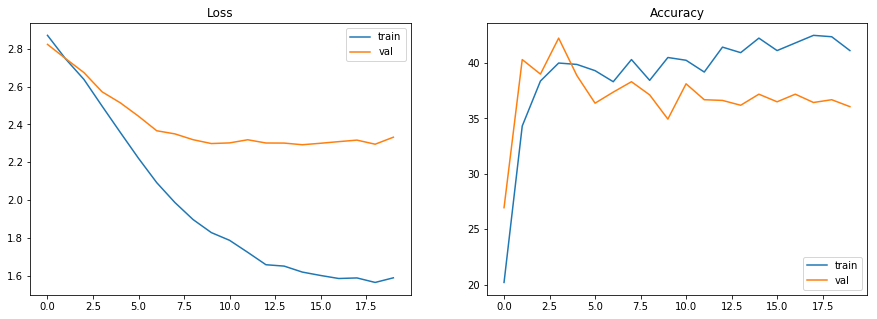

In [26]:
# Plot performance
trainer.plot_performance()

In [27]:
# Test performance
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.1f}%".format(trainer.train_state['test_acc']))

Test loss: 2.31
Test Accuracy: 36.1%


In [0]:
# Save all results
trainer.save_train_state()

In [0]:
class Inference(object):
    def __init__(self, model, vectorizer):
        self.model = model
        self.vectorizer = vectorizer
  
    def predict_nationality(self, surname):
        # Forward pass
        vectorized_surname = torch.tensor(self.vectorizer.vectorize(surname)).view(1, -1)
        self.model.eval()
        y_pred = self.model(vectorized_surname, apply_softmax=True)

        # Top nationality
        y_prob, indices = y_pred.max(dim=1)
        index = indices.item()

        # Predicted nationality
        nationality = vectorizer.nationality_vocab.lookup_index(index)
        probability = y_prob.item()
        return {'nationality': nationality, 'probability': probability}
  
    def predict_top_k(self, surname, k):
        # Forward pass
        vectorized_surname = torch.tensor(self.vectorizer.vectorize(surname)).view(1, -1)
        self.model.eval()
        y_pred = self.model(vectorized_surname, apply_softmax=True)

        # Top k nationalities
        y_prob, indices = torch.topk(y_pred, k=k)
        probabilities = y_prob.detach().numpy()[0]
        indices = indices.detach().numpy()[0]

        # Results
        results = []
        for probability, index in zip(probabilities, indices):
            nationality = self.vectorizer.nationality_vocab.lookup_index(index)
            results.append({'nationality': nationality, 'probability': probability})

        return results

In [30]:
# Load the model
dataset = SurnameDataset.load_dataset_and_load_vectorizer(
    args.split_data_file,args.vectorizer_file)
vectorizer = dataset.vectorizer
model = SurnameModel(input_dim=len(vectorizer.surname_vocab), 
                     hidden_dim=args.hidden_dim, 
                     output_dim=len(vectorizer.nationality_vocab),
                     dropout_p=args.dropout_p)
model.load_state_dict(torch.load(args.model_state_file))
model = model.to(args.device)
print (model.named_modules)

<bound method Module.named_modules of SurnameModel(
  (fc1): Linear(in_features=28, out_features=300, bias=True)
  (dropout): Dropout(p=0.1)
  (fc2): Linear(in_features=300, out_features=18, bias=True)
)>


In [0]:
# Top-k inference
top_k = inference.predict_top_k(surname, k=3)
print ("{}: ".format(surname))
for result in top_k:
    print ("{} → (p={:0.2f})".format(result['nationality'], 
                                     result['probability']))

In [0]:
# Inference
inference = Inference(model=model, vectorizer=vectorizer)
surname = input("Enter a surname to classify: ")
prediction = inference.predict_nationality(surname)
print("{}: {} → p={:0.2f})".format(surname, prediction['nationality'], 
                                   prediction['probability']))